In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [11]:
df = pd.read_csv("../Data/Hourly consumption per cluster South Africa.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)
df.head()


,Cluster,consumption_kWh,CO2_intensity,day,hour
time,,,,,
000,0,57.697082,864.524537,0,00
001,0,55.224566,870.705770,0,01
002,0,54.344372,872.777702,0,02
003,0,54.252020,871.116731,0,03
004,0,63.636753,871.232315,0,04


In [50]:
a = df["consumption_kWh"]*df["CO2_intensity"]
r = a.sum()

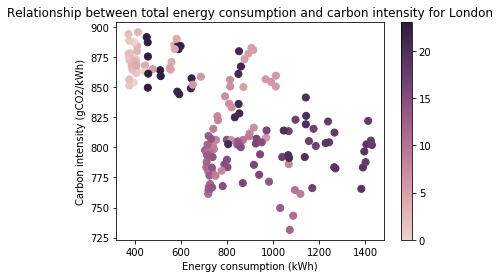

In [12]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z
a['hour'] = a.index.str[1:].astype(int)


cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(a['consumption_kWh'], y = a['CO2_intensity'], c=a['hour'], s=50, cmap=cmap)
f.colorbar(points)


plt.title("Relationship between total energy consumption and carbon intensity for London")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")

plt.savefig("Carbon Intensity vs Consumption London.png")

In [13]:
a['consumption_kWh'].corr(a['CO2_intensity'])

-0.5912801422700213

### Load the best model for consumption-carbon intensity mathing 

CF South Africa Consumption-Carbon intensity model notebook for model comparison

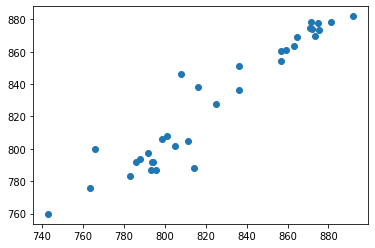

In [14]:
week = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()
week["day"] = week.index.str[:1]
week["hour"] = week.index.str[1:]

z = df.iloc[range(0,168),-3]
week["CO2_intensity"] = z

train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
rf = RandomForestRegressor(max_depth=None, min_samples_split = 2)

X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)


rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
plt.scatter(y_test,y_pred)

## Reduction of energy consumption 

### Peak consumption reduction in cluster 5 

Evaluate the impact a X% reduction in energy consumption of a cluster during evening peak could have on overall consumption and co2 emissions. 

We look at cluster 5 between 6 and 10 pm

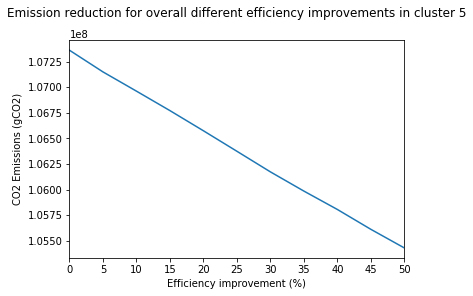

In [12]:
eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
eff["Efficiency"] = 1

for i in range(len(decrease)) : 
    
    eff["Efficiency"] = eff["Efficiency"].where(
        ((eff["hour"] != "18") & (eff["hour"] != "19") & (eff["hour"] != "20")
        & (eff["hour"] != "21") &(eff["hour"] != "22")) | (eff["Cluster"] != 4 ) , decrease[i])
    

    eff["consumption_kWh1"] = eff["consumption_kWh"]*eff["Efficiency"]
    
    a = eff.groupby(eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements in cluster 5", y = 1.08)
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)

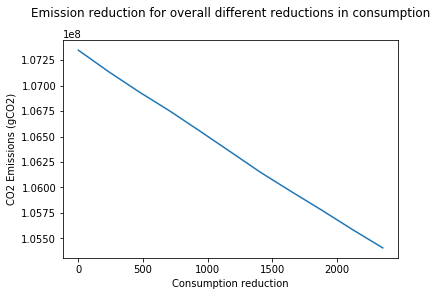

In [15]:
eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
eff["Efficiency"] = 1
saved = [None]*len(decrease)

for i in range(len(decrease)) : 
    
    eff["Efficiency"] = eff["Efficiency"].where(
        ((eff["hour"] != "18") & (eff["hour"] != "19") & (eff["hour"] != "20")
        & (eff["hour"] != "21") &(eff["hour"] != "22")) | (eff["Cluster"] != 4 ) , decrease[i])
    

    eff["consumption_kWh1"] = eff["consumption_kWh"]*eff["Efficiency"]
    saved[i] = eff["consumption_kWh"]*(1-eff["Efficiency"])

    a = eff.groupby(eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

for i in range(len(saved)): 
    saved[i] = saved[i].sum()    

plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction")
plt.title("Emission reduction for overall different reductions in consumption",y=1.08)
#my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
#plt.xticks(decrease,my_xticks)
saved2 = saved
result2 = result
plt.plot(saved2,result2)
#ov_eff['CO2_intensity']


### Overall Cluster 5 Improvement 

11


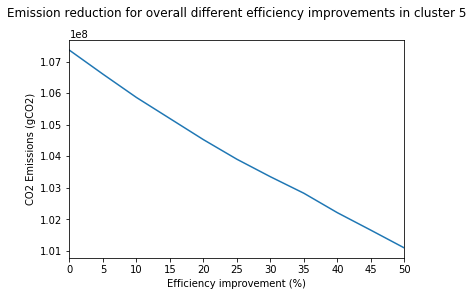

In [14]:
c5_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

c5_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    c5_eff["efficiency"] = c5_eff["efficiency"].where(
        c5_eff["Cluster"] != 4 , decrease[i])
    c5_eff["consumption_kWh1"] = c5_eff["consumption_kWh"]*c5_eff["efficiency"]
    
    a = c5_eff.groupby(c5_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements in cluster 5", y = 1.08)
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)

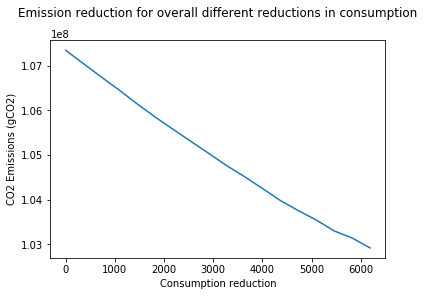

In [16]:
c5_eff = df.copy()

decrease = np.arange(1, 0.65, -0.02)
result = [None]*len(decrease)
saved = [None]*len(decrease)

c5_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    c5_eff["efficiency"] = c5_eff["efficiency"].where(
        c5_eff["Cluster"] != 4 , decrease[i])
    c5_eff["consumption_kWh1"] = c5_eff["consumption_kWh"]*c5_eff["efficiency"]
    saved[i] = c5_eff["consumption_kWh"]*(1-c5_eff["efficiency"])
    a = c5_eff.groupby(c5_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))


    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    
    result[i] = a["Emissions"].sum()

for i in range(len(saved)): 
    saved[i] = saved[i].sum()    

plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction")
plt.title("Emission reduction for overall different reductions in consumption",y=1.08)
#my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
#plt.xticks(decrease,my_xticks)
saved1 = saved
result1 = result
plt.plot(saved1,result1)
#ov_eff['CO2_intensity']


There seems to be a dip at around 25-30% efficiency improvement

### Overall efficiency improvement 

11


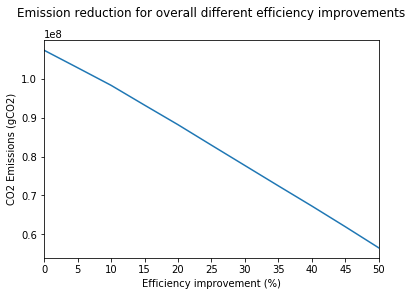

In [17]:
ov_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

columns = decrease

df1 = pd.DataFrame(columns = columns)

ov_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    ov_eff["efficiency"] = decrease[i]
    ov_eff["consumption_kWh1"] = ov_eff["consumption_kWh"]*ov_eff["efficiency"]
    #print(ov_eff["consumption_kWh1"])
    a = ov_eff.groupby(ov_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    result[i] = a["Emissions"].sum()
    #print(ov_eff["Emissions"].sum())

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements",y=1.08)
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)
#ov_eff['CO2_intensity']


3


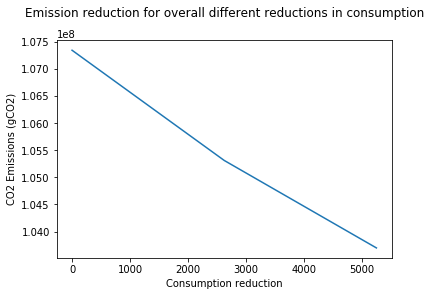

In [23]:
ov_eff = df.copy()

decrease = np.arange(1, 0.95, -0.02)
result = [None]*len(decrease)
print(len(decrease))
saved = [None]*len(decrease)

columns = decrease

df1 = pd.DataFrame(columns = columns)

ov_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    ov_eff["efficiency"] = decrease[i]
    ov_eff["consumption_kWh1"] = ov_eff["consumption_kWh"]*ov_eff["efficiency"]
   # v[i] = ov_eff["consumption_kWh1"]
    saved[i] = ov_eff["consumption_kWh"]*(1-ov_eff["efficiency"])
    a = ov_eff.groupby(ov_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    result[i] = a["Emissions"].sum()
    #print(ov_eff["Emissions"].sum())

    

for i in range(len(saved)): 
    saved[i] = saved[i].sum()    

plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction")
plt.title("Emission reduction for overall different reductions in consumption",y=1.08)
#my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
#plt.xticks(decrease,my_xticks)
plt.plot(saved,result)

#ov_eff['CO2_intensity']


There seems to be 3 zones. Between 0 and 10% the changes is the most important, then between 10 and 40% and then after 40%. The most effective is zone 1 then zone 2 then zone 3

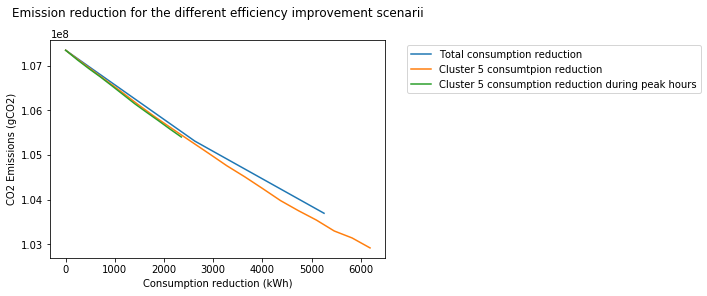

In [24]:
plt.plot(saved,result, label = 'Total consumption reduction')
plt.plot(saved1,result1, label = 'Cluster 5 consumtpion reduction')
plt.plot(saved2,result2, label = 'Cluster 5 consumption reduction during peak hours')
plt.title("Emission reduction for the different efficiency improvement scenarii",y=1.08)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Consumption reduction (kWh)")
plt.legend(bbox_to_anchor=(1.05, 1))


## Moving households from a cluster to another


Move a part of cluster 5 to cluster 2

Get mean consumption per cluster for each time

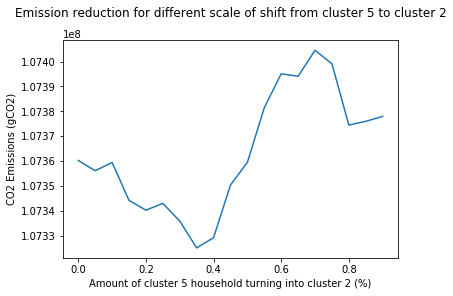

In [17]:
clus = df.copy()

move = np.arange(0, 0.95, 0.05)
result = [None]*len(move)

for i in range(len(result)): 

    c5 = clus[clus["Cluster"] == 4]

    c5["Change"] = move[i]*c5["consumption_kWh"]

    tot = c5['Change'].sum()


    c2 = clus[clus["Cluster"] == 1]
    tot_c2 = c2["consumption_kWh"].sum()

    c2["Perc"] = c2["consumption_kWh"]/tot_c2
    c2.head()
    c2["Perc"].sum()
    c2['Added'] = tot*c2["Perc"]
    c2.head()
    a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

    clus["Change"] = a

    clus["consumption_kWh1"] = clus["consumption_kWh"].where(
        clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
        clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

    a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]

    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

    result[i] = a["Emissions"].sum()

    
    
    
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Amount of cluster 5 household turning into cluster 2 (%)")
plt.title("Emission reduction for different scale of shift from cluster 5 to cluster 2",y=1.08)
plt.plot(move,result)
#ov_eff['CO2_intensity']

Cluster 4 to 2

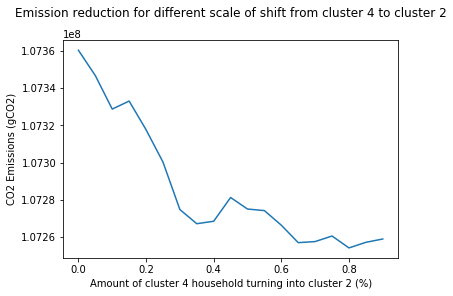

In [18]:
clus = df.copy()

move = np.arange(0, 0.95, 0.05)
result = [None]*len(move)

for i in range(len(result)): 

    c5 = clus[clus["Cluster"] == 3]

    c5["Change"] = move[i]*c5["consumption_kWh"]

    tot = c5['Change'].sum()


    c2 = clus[clus["Cluster"] == 1]
    tot_c2 = c2["consumption_kWh"].sum()

    c2["Perc"] = c2["consumption_kWh"]/tot_c2
    c2.head()
    c2["Perc"].sum()
    c2['Added'] = tot*c2["Perc"]
    c2.head()
    a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

    clus["Change"] = a

    clus["consumption_kWh1"] = clus["consumption_kWh"].where(
        clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
        clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

    a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]

    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

    result[i] = a["Emissions"].sum()

    
    
    
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Amount of cluster 4 household turning into cluster 2 (%)")
plt.title("Emission reduction for different scale of shift from cluster 4 to cluster 2",y=1.08)
plt.plot(move,result)
#ov_eff['CO2_intensity']

Same result as c5 reached for less change, but going beyond leads to re-increase in emission. 

Cluster 1 to 2

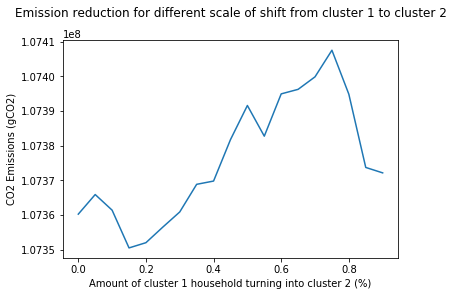

In [19]:
clus = df.copy()

move = np.arange(0, 0.95, 0.05)
result = [None]*len(move)

for i in range(len(result)): 

    c5 = clus[clus["Cluster"] == 0]

    c5["Change"] = move[i]*c5["consumption_kWh"]

    tot = c5['Change'].sum()


    c2 = clus[clus["Cluster"] == 1]
    tot_c2 = c2["consumption_kWh"].sum()

    c2["Perc"] = c2["consumption_kWh"]/tot_c2
    c2.head()
    c2["Perc"].sum()
    c2['Added'] = tot*c2["Perc"]
    c2.head()
    a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

    clus["Change"] = a

    clus["consumption_kWh1"] = clus["consumption_kWh"].where(
        clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
        clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

    a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]

    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

    result[i] = a["Emissions"].sum()

    
    
    
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Amount of cluster 1 household turning into cluster 2 (%)")
plt.title("Emission reduction for different scale of shift from cluster 1 to cluster 2",y=1.08)
plt.plot(move,result)
#ov_eff['CO2_intensity']

Opposite effect for 1 to 2

Best is 4 to 2, but not a lot of impact

As the correlation is negative, the relation is opposite to the one in the UK

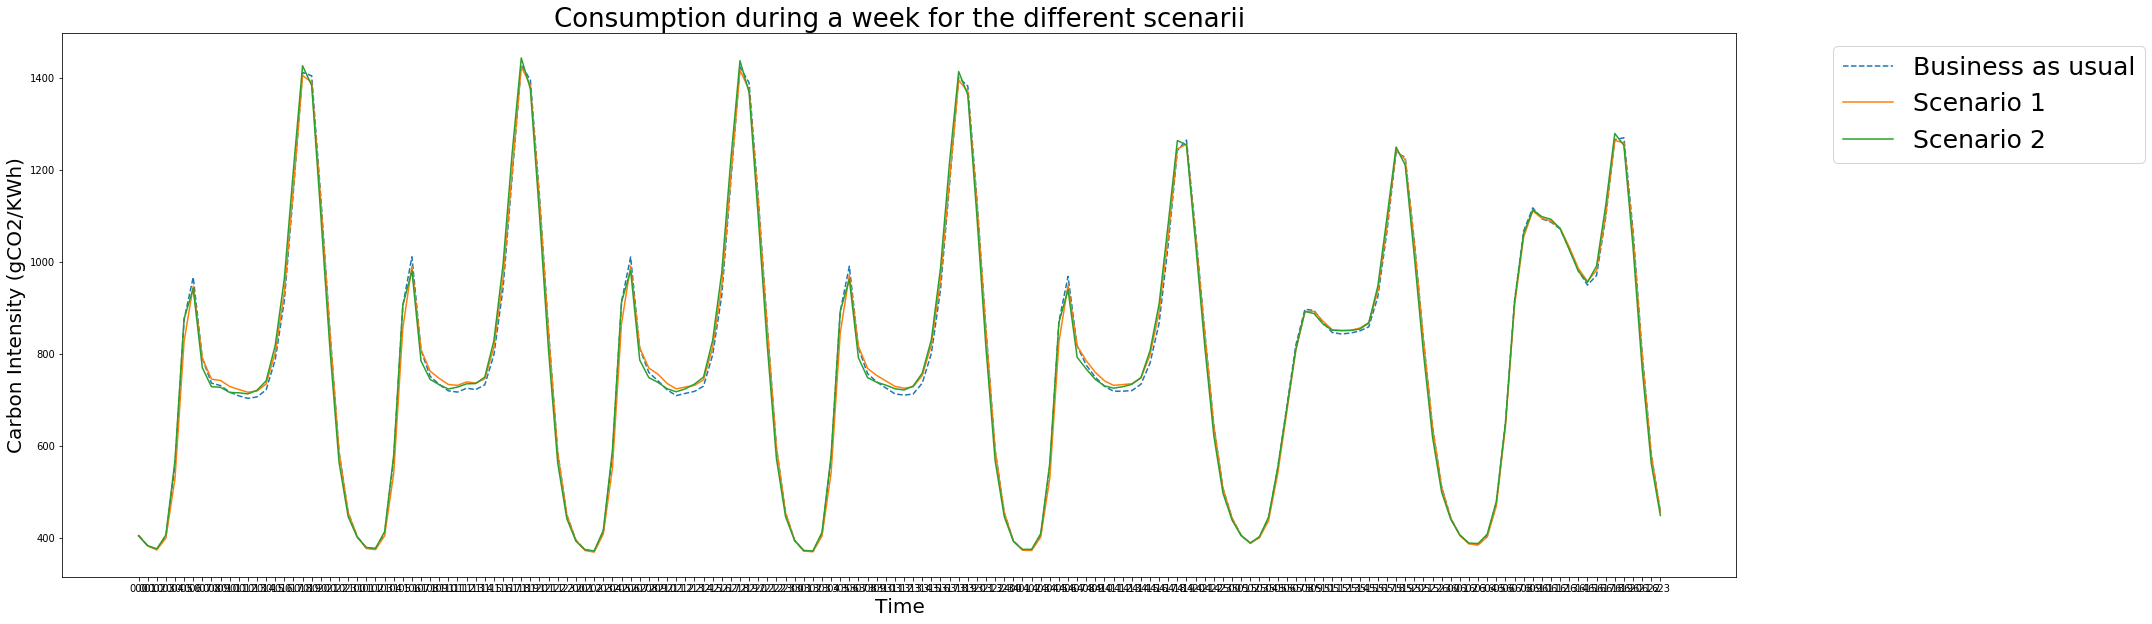

In [25]:
c = df.copy()
move = 0.4


#Senario 1
c_s1 = df.copy()
c5_s1 = c_s1[c_s1["Cluster"] == 4]

c5_s1["Change"] = move*c5_s1["consumption_kWh"]

tot_c5_s1 = c5_s1['Change'].sum()

c2_s1 = c_s1[c_s1["Cluster"] == 1]
tot_c2_s1 = c2_s1["consumption_kWh"].sum()

c2_s1["Perc"] = c2_s1["consumption_kWh"]/tot_c2_s1

c2_s1["Perc"].sum()
c2_s1['Added'] = tot_c5_s1*c2_s1["Perc"]
c2_s1.head()
a_s1 = [0]*168 + list(c2_s1["Added"]) + [0]*2*168 + list(c5_s1["Change"])

c_s1["Change"] = a_s1

c_s1["consumption_kWh1"] = c_s1["consumption_kWh"].where(
    c_s1["Cluster"] != 4, c_s1["consumption_kWh"]- c_s1["Change"]).where(
    c_s1["Cluster"] != 1, c_s1["consumption_kWh"] + c_s1["Change"])

grp_s1 = c_s1.groupby(c_s1.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
grp_s1["day"] = grp_s1.index.str[:1]
grp_s1["hour"] = grp_s1.index.str[1:]
grp_s1['CO2_intensity'] = rf.predict(np.array(grp_s1[['consumption_kWh1','day','hour']], 
                dtype = pd.Series))



#Senario 2
c_s2 = df.copy()
c4_s2 = c_s2[c_s2["Cluster"] == 3]

c4_s2["Change"] = move*c4_s2["consumption_kWh"]

tot_c4_s2 = c4_s2['Change'].sum()

c2_s2 = c_s2[c_s2["Cluster"] == 1]
tot_c2_s2 = c2_s2["consumption_kWh"].sum()

c2_s2["Perc"] = c2_s2["consumption_kWh"]/tot_c2_s2

c2_s2["Perc"].sum()
c2_s2['Added'] = tot_c4_s2*c2_s2["Perc"]
c2_s2.head()
a_s2 = [0]*168 + list(c2_s2["Added"]) + [0]*2*168 + list(c4_s2["Change"])

c_s2["Change"] = a_s2

c_s2["consumption_kWh1"] = c_s2["consumption_kWh"].where(
    c_s2["Cluster"] != 4, c_s2["consumption_kWh"]- c_s2["Change"]).where(
    c_s2["Cluster"] != 1, c_s2["consumption_kWh"] + c_s2["Change"])

grp_s2 = c_s2.groupby(c_s2.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
grp_s2["day"] = grp_s2.index.str[:1]
grp_s2["hour"] = grp_s2.index.str[1:]

grp_s2['CO2_intensity'] = rf.predict(np.array(grp_s2[['consumption_kWh1','day','hour']], 
                dtype = pd.Series))





figure(figsize=(30,10))

b = c.groupby(c.index)["consumption_kWh"].apply(lambda x: np.sum(x)).to_frame()
plt.plot(b, linestyle='dashed', label = "Business as usual")
plt.plot(grp_s1["consumption_kWh1"], label = "Scenario 1")
plt.plot(grp_s2["consumption_kWh1"], label = "Scenario 2")
plt.title("Consumption during a week for the different scenarii",size = 26)
plt.xlabel("Time", size = "20")
plt.ylabel("Carbon Intensity (gCO2/KWh)", size = "20")
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 25})

plt.savefig("Consumption during a week for the different scenarii.png")

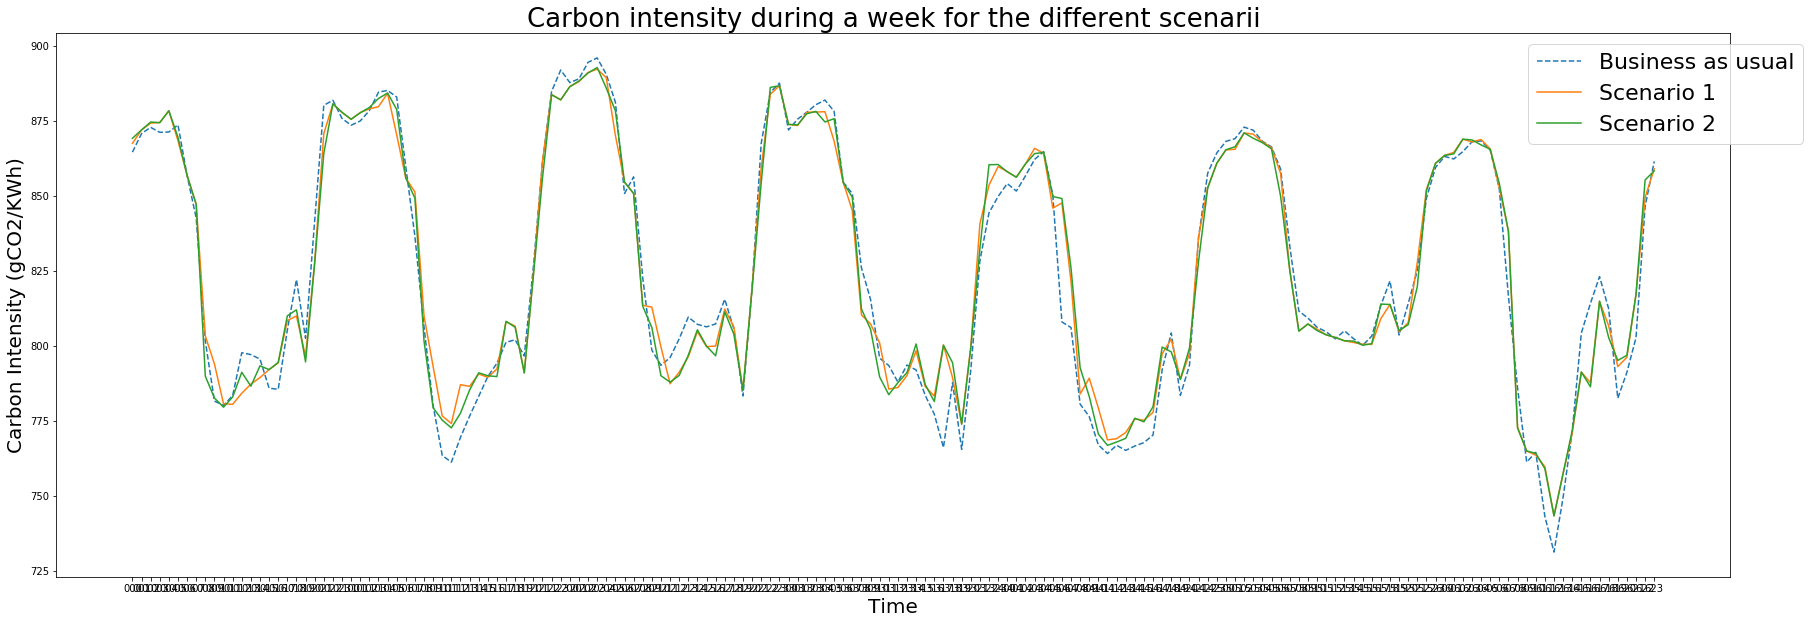

In [33]:
figure(figsize=(30,10))


a = pd.read_csv("../Data/SA_carbon_intensity.csv")
plt.plot(a["Emission_Intensity"],linestyle='dashed', label = "Business as usual")
plt.plot(grp_s1['CO2_intensity'], label = "Scenario 1")
plt.plot(grp_s2['CO2_intensity'], label = "Scenario 2")
plt.title("Carbon intensity during a week for the different scenarii",size = 26)
plt.xlabel("Time", size = "20")
plt.ylabel("Carbon Intensity (gCO2/KWh)", size = "20")
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 22})

plt.savefig("Carbon intensity during a week for the different scenarii.png")


In [30]:
a.head()

,Weekday,Hour,Emission_Intensity
0,0,0,864.524537
1,0,1,870.705770
2,0,2,872.777702
3,0,3,871.116731
4,0,4,871.232315


In [93]:
clus = df.copy()

result = []
to = []
fro = []
for i in range(0,5): 
    for j in range(0,5): 

        c5 = clus[clus["Cluster"] == i]

        c5["Change"] = 0.4*c5["consumption_kWh"]

        tot = c5['Change'].sum()


        c2 = clus[clus["Cluster"] == j]
        tot_c2 = c2["consumption_kWh"].sum()

        c2["Perc"] = c2["consumption_kWh"]/tot_c2
        c2.head()
        c2["Perc"].sum()
        c2['Added'] = tot*c2["Perc"]
        c2.head()
        a = [0]*168 + list(c2["Added"]) + [0]*2*168 + list(c5["Change"])

        clus["Change"] = a

        clus["consumption_kWh1"] = clus["consumption_kWh"].where(
            clus["Cluster"] != 4, clus["consumption_kWh"]- clus["Change"]).where(
            clus["Cluster"] != 1, clus["consumption_kWh"] + clus["Change"])

        a = clus.groupby(clus.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
        a["day"] = a.index.str[:1]
        a["hour"] = a.index.str[1:]

        a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                        dtype = pd.Series))

        #ov_eff["CO2_intensity"]
        a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]

        result.append(a["Emissions"].sum())
        to.append(j+1)
        fro.append(i+1)
        

        
res = pd.DataFrame(list(zip(result, to, fro)), columns =['Reduction','To','From']) 

In [94]:
res.head()
#res["Reduction"] = 107348424.81435384 -res["Reduction"]

,Reduction,To,From
0,1.073484e+08,1,1
1,1.073348e+08,2,1
2,1.073122e+08,3,1
3,1.073325e+08,4,1
4,1.073495e+08,5,1


In [95]:
er = res.pivot(index='To', columns='From', values='Reduction')

In [96]:
er = 107348424.81435384 - er
er


From,1,2,3,4,5
To,,,,,
1,0.000000,-4.931402e+05,-5.241972e+05,-689935.530346,-12363.629885
2,13660.014985,1.490116e-08,1.901389e+04,98395.353891,39903.988100
3,36179.001983,-6.646712e+04,1.490116e-08,19187.311502,43157.233134
4,15970.082306,-6.861194e+04,-1.474444e+04,0.000000,45632.310379
5,-1045.551421,-3.569209e+05,-3.432740e+05,-275182.013351,0.000000


In [78]:
for i in range(0,4):
    print(er.iloc[:,i])

0.0
1.4901161193847656e-08
1.4901161193847656e-08
0.0


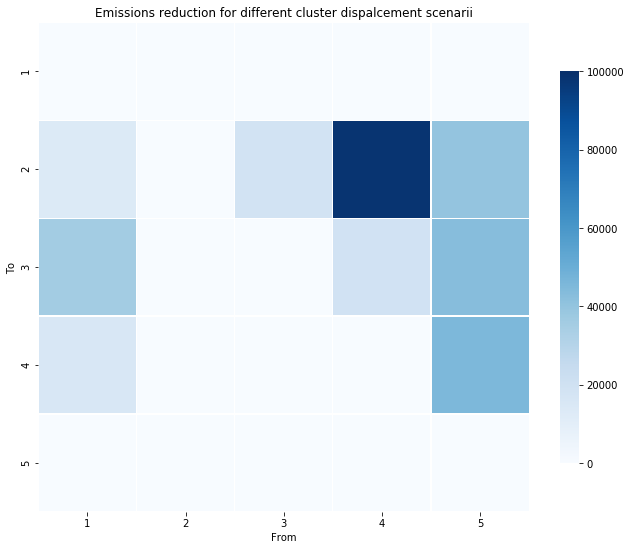

In [100]:
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sns.heatmap(er, cmap="Blues", vmin= 0, vmax=100000,
           linewidth=0.3, cbar_kws={"shrink": .8}, label = 'Emission reduction (gCO2)')
plt.title("Emissions reduction for different cluster dispalcement scenarii")
plt.show()
